<a href="https://colab.research.google.com/github/yulia-vitkovskaya/Bert_vs_XLNet/blob/main/XLNet_vs_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация текста с помощью BERT

Это руководство содержит полный код для точной настройки BERT для выполнения анализа настроений на наборе данных из текстовых обзоров фильмов IMDB.
В дополнение к обучению модели будет реализована предварительное преобразование текста в соответствующий формат.

Содержание блока:

- Загрузка набора данных IMDB
- Загрузка модели BERT из TensorFlow Hub
- Создание своей собственной модели, объединяя BERT с классификатором
- Обучение своей собственной модели, тонко настраивая BERT как часть этого
- Сохранение модели и использование ее для классификации предложений

## О BERT

[BERT](https://arxiv.org/abs/1810.04805 ) и другие архитектуры трансформаторных кодировщиков были чрезвычайно успешны при решении различных задач в NLP (обработке естественного языка). Они вычисляют векторно-пространственные представления естественного языка, которые подходят для использования в моделях глубокого обучения. Семейство моделей BERT использует архитектуру Transformer encoder для обработки каждого токена входного текста в полном контексте всех токенов до и после, отсюда и название: Двунаправленные представления кодера от Transformers.

Модели BERT обычно предварительно обучаются на большом объеме текста, а затем точно настраиваются для конкретных задач.

## Установка

In [ ]:
# Установка зависимостей предварительной обработки для входных данных BERT
!pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    

В тетради будет использован оптимизатор AdamW из [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 18.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=f2d77c7c377f8c6328f9020ba82e018428b42667f6a45cbc048e1a990477c077
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # для создания AdamW оптимизатора

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Анализ настроений

Этот блокнот обучает модель анализа настроений классифицировать рецензии на фильмы как *положительные* или *отрицательные*, основываясь на тексте рецензии.

Здесь будет использован [Большой набор данных для просмотра фильмов](http://ai.stanford.edu/~amaas/data/sentiment/), содержащий текст из 50 000 рецензий на фильмы из [Internet Movie Database](https://www.imdb.com/).

### Загрузка набора данных IMDB

Загрузим и извлекем набор данных, затем изучим структуру каталогов.

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 15s 0us/step


Далее будет использована утилита `text_dataset_from_directory` для создания файла с надписью `tf.data.Dataset".

Набор данных IMDB уже разделен на обучающий и тестовый, но в нем отсутствует набор для проверки. Давайте создадим набор проверки, используя разделение обучающих данных в соотношении 80:20, используя приведенный ниже аргумент `validation_split`.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Обзор нескольких отзывов:

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Отзыв: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Оценка : {label} ({class_names[label]})')

Отзыв: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Оценка : 0 (neg)
Отзыв: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they 

Была выбрана модель Small-BERT

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

## Модель предварительной обработки

Вводимые текстовые данные должны быть преобразованы в числовые идентификаторы токенов и упорядочены в нескольких тензорах перед вводом в BERT. TensorFlow Hub предоставляет соответствующую модель предварительной обработки, которая реализует это преобразование с использованием TF ops из библиотеки TF.text.

Примечание: Мы загрузим модель предварительной обработки в слой [hub.Keras](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer), чтобы создать свою точно настроенную модель. Это предпочтительный API для загрузки сохраненной модели в стиле TF2 из TF Hub в модель Kertas.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Попробуем модель предварительной обработки некоторого текста и посмотрим на результат:

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Теперь у нас есть 3 результата предварительной обработки, которые использовала бы лучшая модель (`input_words_id`, `input_mask` и `input_type_ids`).

Некоторые другие важные моменты:
- Ввод усечен до 128 токенов.
- `input_type_ids` имеет только одно значение (0), потому что это ввод одного предложения.

Поскольку этот текстовый препроцессор является моделью TensorFlow, он может быть включен непосредственно в нашу модель.

## ## Использование модели

Прежде чем внедрять BERT в нашу собственную модель, взглянем на ее выходные данные.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Загруженный BERT: {tfhub_handle_encoder}')
print(f'Размерность объединенных выходных данных:{bert_results["pooled_output"].shape}')
print(f'Объединенные выходные значения:{bert_results["pooled_output"][0, :12]}')
print(f'Размерность выходных данных последовательности:{bert_results["sequence_output"].shape}')
print(f'Значения выходных данных:{bert_results["sequence_output"][0, :12]}')

Загруженный BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Размерность объединенных выходных данных:(1, 512)
Объединенные выходные значения:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Размерность выходных данных последовательности:(1, 128, 512)
Значения выходных данных:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


BERT модель возвращает карту с 3 важными ключами: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` представляет каждую входную последовательность в целом. Размерность - "[batch_size, H]".
- `sequence_output` представляет каждый входной токен в контексте. Размерность - `[batch_size, seq_length, H]`.
- `encoder_outputs` - это промежуточные активации блоков трансформатора `L`. `outputs["encoder_outputs"][i]` - это тензор формы `[batch_size, seq_length, 1024]` с выходами i-го блока трансформатора, для `0 <= i < L`. Последнее значение списка равно `sequence_output`.

Для точной настройки используем массив `pooled_output`.

## Определение модели

Мы создадим очень простую тонко настроенную модель с моделью предварительной обработки одним Dense слоем и Dropout слоем.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Проверим, что модель запускается с выводом preprocessing модели.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.34827566]], shape=(1, 1), dtype=float32)


Вывод, конечно, бессмыслен, потому что модель еще не была обучена.

Взглянем на структуру модели.

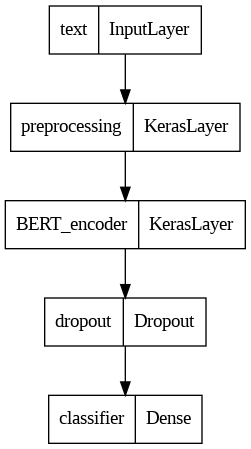

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Обучение модели

Теперь у нас есть все компоненты для обучения модели, включая preprocessing модуль, кодировщик BERT, данные и классификатор.

### Функция потерь

Поскольку у нас стоит задача бинарной классификации и модель выводит вероятность, мы будем использовать функцию потерь `losses.BinaryCrossentropy`.

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Оптимизатор

Для точной настройки давайте воспользуемся тем же оптимизатором, с которым изначально обучался БЕРТ: "Адаптивный момент" (Adam). Этот оптимизатор минимизирует потери при прогнозировании и выполняет регуляризацию путем уменьшения веса (без использования моментов), которая также известна как [AdamW](https://arxiv.org/abs/1711.05101 ).

Для скорости обучения (`init_lr`) мы будем использовать тот же график, что и для предварительной тренировки BERT: линейное снижение условной начальной скорости обучения, предваряемое линейной фазой разминки в течение первых 10% шагов обучения (`num_warmup_steps`). Начальная скорость обучения будет меньше для точной настройки (лучшая из 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Загрузка модели BERT и обучение

Используя `classifier_model`, который был создан ранее, мы можем скомпилировать модель с потерями, метрикой и оптимизатором.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Обучение модели {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Обучение модели https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
513/625 [=======================>......] - ETA: 21:58 - loss: 0.4994 - binary_accuracy: 0.7336

### Оценка модель

Посмотрим, как работает модель. Будут возвращены два значения: потери (число, представляющее ошибку, чем меньше значение, тем лучше) и точность.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

### Построение графика точности и потерь с течением времени

На основе объекта `История`, возвращаемого `model.fit()` мы можем построить график потерь при обучении и проверке для сравнения, а также точности обучения и проверки:

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r для "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b для "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

На этом графике красные линии представляют потери при обучении и точность, а синие линии - потери при проверке и точность.

## Экспорт для вывода

Теперь мы просто сохраняем свою точно настроенную модель для последующего использования.

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Перезагрузим модель, чтобы мы могли попробовать ее с моделью, которая все еще находится в памяти.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Здесь мы можем протестировать свою модель на любом предложении, которое хотим, просто добавив в приведенную ниже переменную examples.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # это те же предложения, что были испробованы ранее
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Если мы хотим использовать свою модель на [TF Serving](https://www.tensorflow.org/tfx/guide/serving ), нужно помнить, что он вызовет SavedModel через одну из своих именованных сигнатур. В Python можно протестировать их следующим образом:

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

# Классификация текста с помощью XLNet

## О XLNet

XLNet - это модель для обработки естественного языка (NLP), основанная на трансформерной архитектуре. Она была разработана для решения задач связанных с обработкой текстов, таких как семантическая однозначность, машинный перевод и анализ тональности. XLNet обучается на больших корпусах текста с использованием алгоритма самоконтроля, что позволяет ей лучше учитывать контекст и зависимости между словами. Это делает XLNet одной из самых точных и мощных моделей в области NLP.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import pandas as pd
import math
import numpy as np
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [ ]:
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

In [ ]:
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)

Проверка версии библиотеки

In [ ]:
!pip list | grep -E 'transformers|torch|Keras'

В этом блоке мы рассмотрим, как выполнять классификацию текста с помощью XL Net, включая:

- Загрузку и предварительную обработку данных
- Данные синтаксического анализа
- Создайте обучающие данные
- Обучение модели
- Оценка результата

## Загрузка данных

In [ ]:
df_data = pd.read_csv('text_classification_dataset.csv', sep=",", encoding="utf-8", names=['labels','texts'])

In [ ]:
df_data.columns

In [ ]:
df_data.head(20)

In [ ]:
df_data.labels.unique()

Проанализируем распределение меток

In [ ]:
df_data.labels.value_counts()

## Анализ данных

Пример данных

In [ ]:
sentences = df_data.texts.to_list()
sentences[0]

In [ ]:
labels = df_data.labels.to_list()
print(labels[0])

Внесение названия тега в индекс для обучения

In [ ]:
# 0:negative, 1: positive
tag2idx={'0': 0,
 '1': 1}

tag2idx

In [ ]:
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

tag2name

## Создание обучающих данных
Преобразование необработанных данных в обучаемые данные для XL Net, включает:

- Настройку среды графического процессора
- Загрузку токенизатора и токенизацию
- Набор 3 embedding, token embedding, mask word embedding, segmentation embedding
- Деление набора данных на обучающие и проверяющие выборки, затем загрузка их в dataloader

**Настройка среды графического процессора (необязательно)**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
n_gpu

## Загрузка токенизатора

Установливаем фрагмент предложения с помощью 'pip install sentence piece'

In [ ]:
vocabulary = 'models/xlnet-base-cased/xlnet-base-cased-spice.model'

In [ ]:
max_len  = 64

In [ ]:
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)

## Установка текстового ввода

- token id embedding
- mask embedding
- segment embedding

Этот процесс сильно отличается от процесса BERT

In [ ]:
max_len  = 64

full_input_ids = []
full_input_masks = []
full_segment_ids = []

SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

for i,sentence in enumerate(sentences):
    # Токенизируем предложение
    tokens_a = tokenizer.encode(sentence)

    # Обрезаем строку текста
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]


    tokens = []
    segment_ids = []

    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)

    # Добавляем <sep> токен
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)


    # Добавляем <cls> токен
    tokens.append(CLS_ID)
    segment_ids.append(SEG_ID_CLS)

    input_ids = tokens

    # Маска имеет значение 0 для реальных токенов и 1 для дополнительных токенов. Учитываются только реальные
    # токены.
    input_mask = [0] * len(input_ids)

    if len(input_ids) < max_len:
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len

    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)

    if 3 > i:
        print("No.:%d"%(i))
        print("sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")

### Установка меток

In [ ]:
tags = [tag2idx[str(lab)] for lab in labels]
print(tags[0])

## Деление данных на train и validation выборки

70% на обучение, 30% на валидацию

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(full_input_ids, tags,full_input_masks,full_segment_ids,
                                                            random_state=4, test_size=0.3)

In [ ]:
len(tr_inputs),len(val_inputs),len(tr_segs),len(val_segs)

**Преобразование данных в тензор**

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)

**Перемещение данных в загрузчик данных**

In [ ]:
batch_num = 32

In [ ]:
# Установка token embedding, attention embedding, segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks,val_segs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

## Train модель

Загрузим модель XLNet

In [ ]:
# В этом документе содержатся файлы configuration(txt) и weight(bin)
# Папка должна содержать: pytorch_model.bin, config.json

model_file_address = 'models/xlnet-base-cased'

In [ ]:
# # Загрузим конфигурацию и вес с помощью from_preferenced()
# # Рекомендуется загрузить модель перед использованием
# Загрузите модель с "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-pytorch_model.bin"
# Загрузите модель с "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json"
# # ВНИМАНИЕ!, переименуйте "xlnet-base-cased-pitch_model.bin" в "pytorch_model.bin"
# # переименуйте "xlnet-base-cased-config.json" в "config.json"
model = XLNetForSequenceClassification.from_pretrained(model_file_address,num_labels=len(tag2idx))

In [ ]:
model

In [ ]:
epochs = 5
max_grad_norm = 1.0

In [ ]:
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

### Установим метод точной настройки

In [ ]:
# True: точная настройка всех слоев
# False: только точная настройка слоев классификатора
# # Поскольку XLNet в 'pytorch_transformer' не содержал слоев классификатора
# # FULL_FINE TUNING = True необходимо установить значение True
FULL_FINE TUNING = True

In [ ]:
if FULL_FINETUNING:
    # Точная настройка всех параметров слоя модели
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Только точная настройка параметров классификатора
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

## Fine-tuing модель

In [ ]:
model.train();

In [ ]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # добавление batch в графический процессор
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch

        # прямой проход
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # При использовании нескольких графических процессоров усредняйте
            loss = loss.mean()

        # обратный проход
        loss.backward()

        # track train потери
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # параметры обновлени
        optimizer.step()
        optimizer.zero_grad()

    # train loss за эпоху
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

## Сохранение модели

In [ ]:
xlnet_out_address = 'models/xlnet_out_model/tc02'

In [ ]:
if not os.path.exists(xlnet_out_address):
        os.makedirs(xlnet_out_address)

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model

In [ ]:
output_model_file = os.path.join(xlnet_out_address, "pytorch_model.bin")
output_config_file = os.path.join(xlnet_out_address, "config.json")

In [ ]:
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(xlnet_out_address)

## Загрузка модели

In [ ]:
model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=len(tag2idx))

## Оценка модели

In [ ]:
model.eval();

In [ ]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [ ]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

y_true = []
y_predict = []
print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch

    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]

    # Получение результата textclassification predict
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)

    # Сохраняйте прогнозируемые и реальные результаты маркировки для анализа
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)

    for real_result in label_ids.tolist():
        y_true.append(real_result)


    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(val_inputs)
loss = tr_loss/nb_tr_steps
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'loss': loss}
report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true))


# Сравнительная характеристика

Архитектура модели BERT:
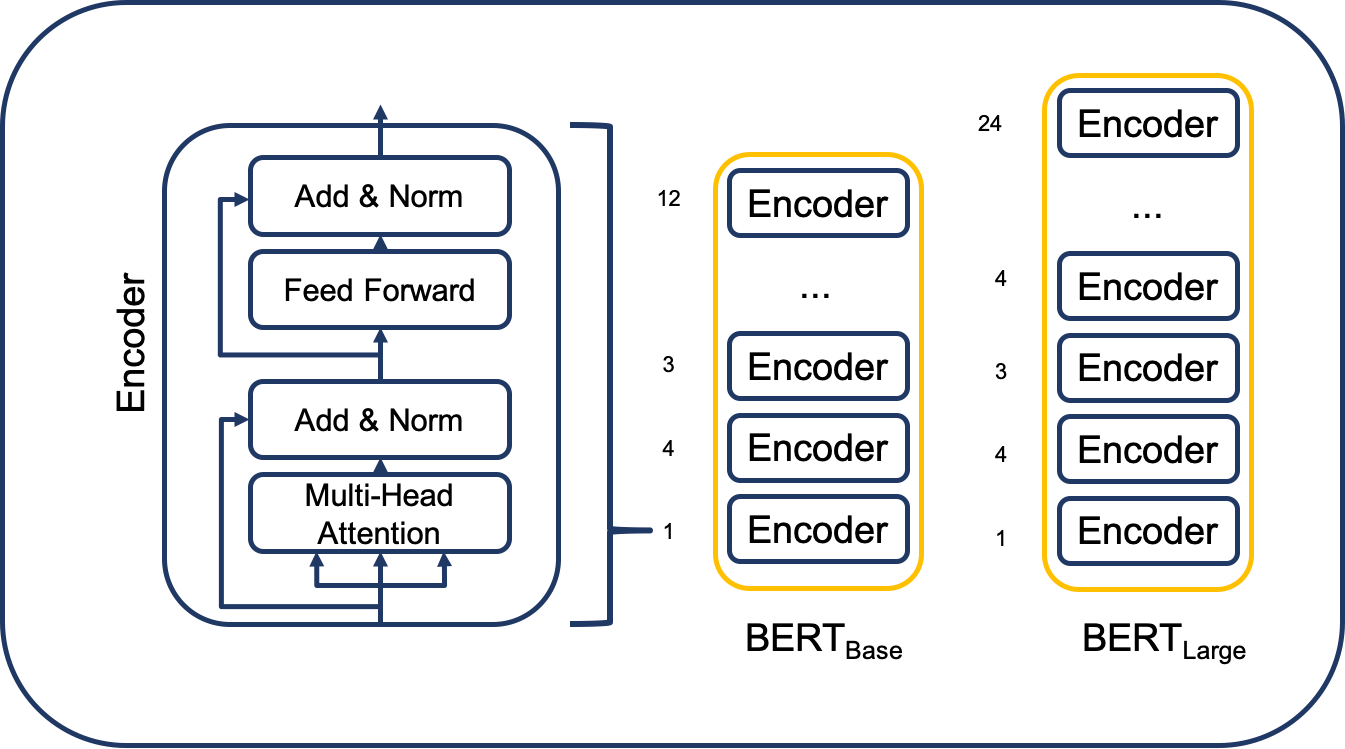
Архитектура модели XLNet:
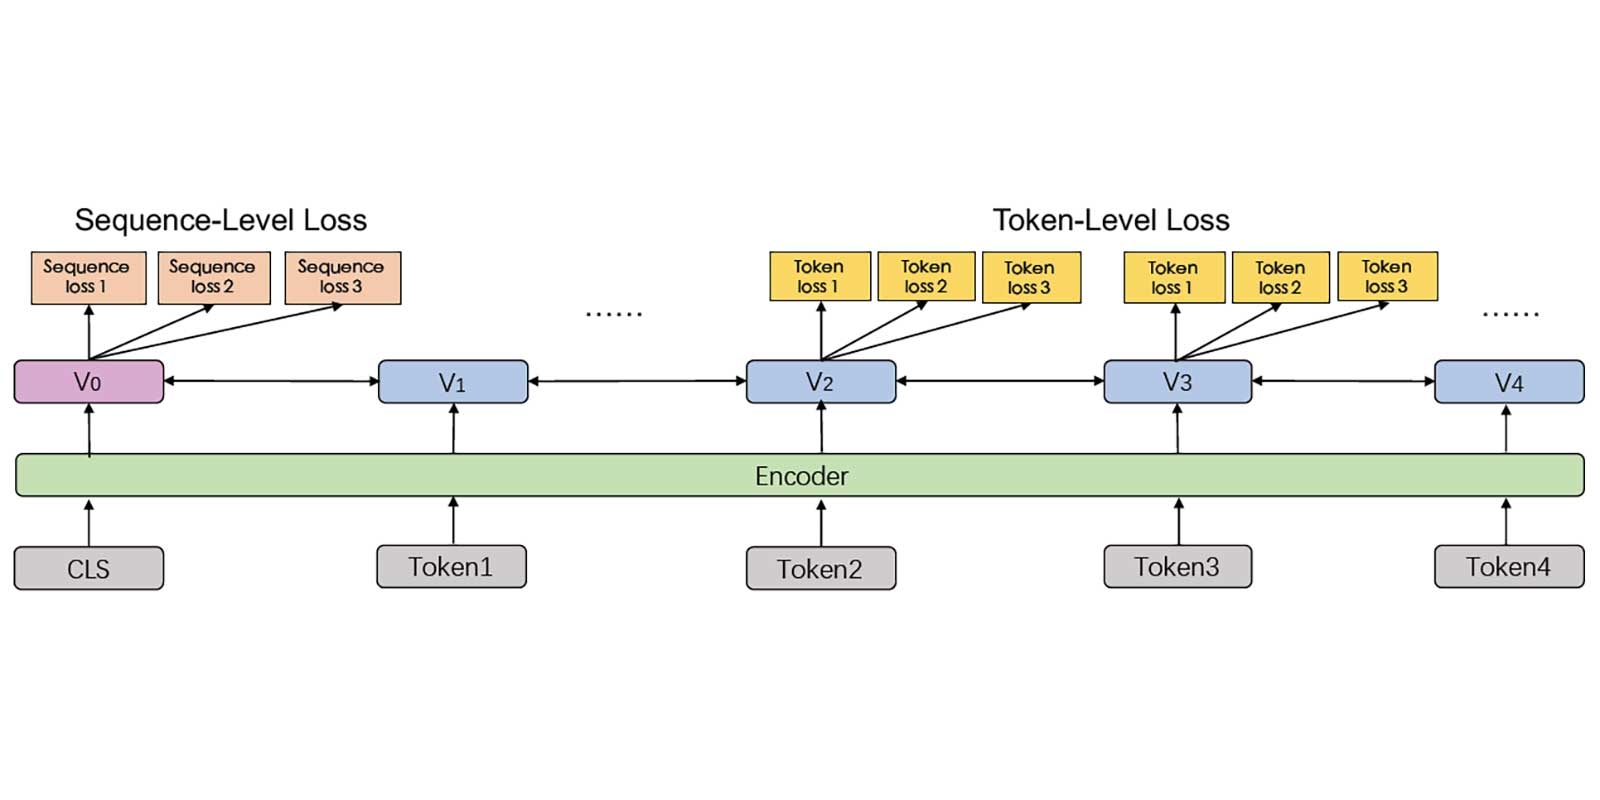

BERT (Bidirectional Encoder Representations from Transformers) и XLNet - это две известные модели трансформеров для обработки естественного языка (NLP). Вот некоторые основные различия между ними:

1. Обучение: BERT обучается на основе задачи предсказания маскированных слов (MLM) и предсказания следующего предложения (NSP), в то время как обучение XLNet основано на алгоритме самоконтроля, который позволяет модели учитывать контекст и зависимости между словами.

2. Архитектура: Обе модели основаны на трансформерной архитектуре, но XLNet включает расширения, такие как перестановочный механизм и предварительное обучение на задаче предсказания перестановки, что позволяет ей лучше учитывать зависимости между словами относительно их порядка.

3. Производительность: Несмотря на то, что обе модели показывают высокую производительность в различных задачах NLP, некоторые исследования показывают, что XLNet может быть более эффективной в некоторых задачах, таких как семантическая однозначность, благодаря своему методу обучения.

В целом, обе модели являются выдающимися достижениями в области NLP, и выбор между ними может зависеть от конкретной задачи и требуемой производительности.

Необходимые объёмы вычислений:
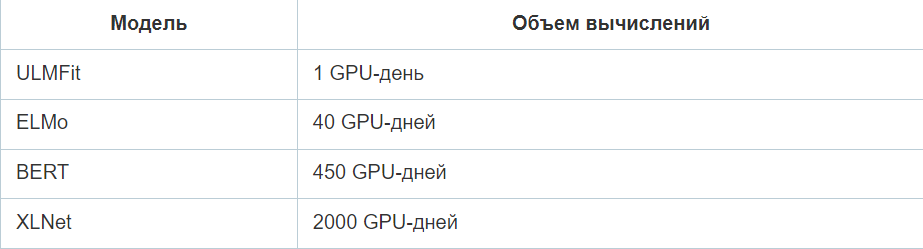